# Exploratory Data Analysis (EDA)

**Purpose**: This notebook explores the self-driving vehicle dataset to understand:
- What the data looks like
- How many samples we have for each steering direction
- Whether there are any problems with the data
- How to split the data for training and testing

**Why EDA is important**: Before building any machine learning model, we need to understand our data. This helps us:
1. Choose the right models
2. Avoid common mistakes
3. Explain why our models work or fail

## 1. Setup: Import Libraries

**What are libraries?** Pre-written code that helps us do common tasks.

- `numpy`: Math operations on arrays (lists of numbers)
- `matplotlib`: Draw plots and charts
- `seaborn`: Make prettier charts
- `sklearn`: Machine learning tools

In [4]:
# Import libraries
import numpy as np                          # For working with arrays of numbers
import matplotlib.pyplot as plt             # For creating plots
import seaborn as sns                       # For creating nice-looking plots
from sklearn.decomposition import PCA       # For reducing dimensions (explained later)
from collections import Counter             # For counting things

# Settings to make plots look better
plt.style.use('default')                    # Use default plot style
sns.set_palette("husl")                     # Use colorful palette
%matplotlib inline
# Show plots inside the notebook


## 2. Load the Dataset

**What is our dataset?** A `.npy` file containing:
- Images: 64×64 grayscale pictures from the vehicle camera
- Labels: Steering direction (-1 = left, 0 = forward, 1 = right)

**Why .npy format?** It's a NumPy file format that stores arrays efficiently.

In [5]:
# Load the dataset
# np.load() reads a .npy file
# allow_pickle=True lets us load this specific file format
data = np.load('../data/training_data-SIZE10000-TIME80557.npy', allow_pickle=True)

# Print basic information
print(f"Total number of samples: {len(data)}")
print(f"Type of data: {type(data)}")
print(f"First sample structure: image shape = {data[0][0].shape}, label = {data[0][1]}")

Total number of samples: 9900
Type of data: <class 'numpy.ndarray'>
First sample structure: image shape = (64, 64), label = 0


## 3. Separate Images (X) and Labels (y)

**Convention in machine learning**:
- `X` = features (input data) = images
- `y` = labels (what we want to predict) = steering directions

**Why separate them?** Most machine learning functions expect X and y as separate inputs.

In [6]:
# Extract images (X) and labels (y)
# sample[0] = image, sample[1] = label
X = np.array([sample[0] for sample in data])  # All images
y = np.array([sample[1] for sample in data])  # All labels

print(f"X shape: {X.shape}")  # Should be (9900, 64, 64)
print(f"y shape: {y.shape}")  # Should be (9900,)
print(f"Unique labels: {np.unique(y)}")  # Should be [-1, 0, 1]

X shape: (9900, 64, 64)
y shape: (9900,)
Unique labels: [-1  0  1]


## 4. Class Distribution

**Purpose**: Count how many samples we have for each steering direction.

**Why this matters**: If we have many more "forward" samples than "left" or "right", the model might:
- Always predict "forward" (lazy strategy)
- Perform poorly on turns

This is called **class imbalance**.

In [7]:
# Count samples for each class
class_counts = Counter(y)  # Counter counts occurrences

# Create a readable summary
label_names = {-1: 'Left', 0: 'Forward', 1: 'Right'}
total = len(y)

print("Class Distribution:")
print("-" * 50)
for label in [-1, 0, 1]:
    count = class_counts[label]
    percentage = (count / total) * 100
    print(f"{label_names[label]:8s} (label={label:2d}): {count:5d} samples ({percentage:5.1f}%)")
print("-" * 50)
print(f"Total: {total} samples")

Class Distribution:
--------------------------------------------------
Left     (label=-1):  1620 samples ( 16.4%)
Forward  (label= 0):  7343 samples ( 74.2%)
Right    (label= 1):   937 samples (  9.5%)
--------------------------------------------------
Total: 9900 samples


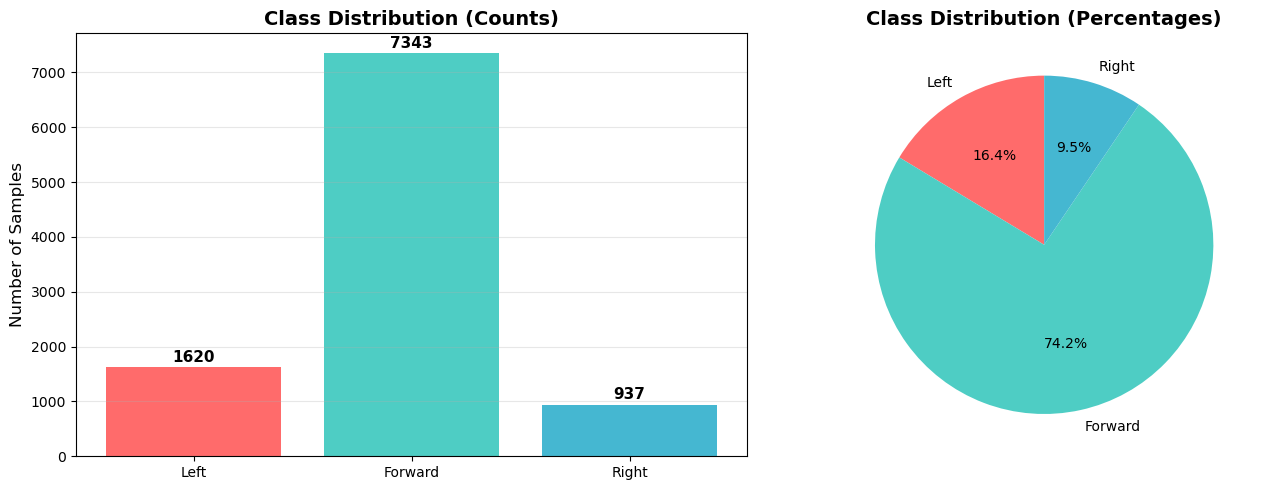


⚠️ KEY OBSERVATION:
Forward class has 7.8x more samples than Right class!
This severe imbalance will likely cause the model to bias toward 'Forward' predictions.


In [8]:
# Visualize class distribution with bar chart
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
labels = ['Left', 'Forward', 'Right']
counts = [class_counts[-1], class_counts[0], class_counts[1]]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

axes[0].bar(labels, counts, color=colors)
axes[0].set_ylabel('Number of Samples', fontsize=12)
axes[0].set_title('Class Distribution (Counts)', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Add count labels on bars
for i, (label, count) in enumerate(zip(labels, counts)):
    axes[0].text(i, count + 100, str(count), ha='center', fontsize=11, fontweight='bold')

# Pie chart
axes[1].pie(counts, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
axes[1].set_title('Class Distribution (Percentages)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Key observation
print("\n⚠️ KEY OBSERVATION:")
print(f"Forward class has {class_counts[0] / class_counts[1]:.1f}x more samples than Right class!")
print("This severe imbalance will likely cause the model to bias toward 'Forward' predictions.")

## 5. Visualize Sample Images

**Purpose**: Look at actual images to understand:
- What does the camera see?
- Do different steering directions look visually different?
- Are labels correct?

**What to look for**:
- Track surface (light gray)
- Track edges (black)
- Vehicle position

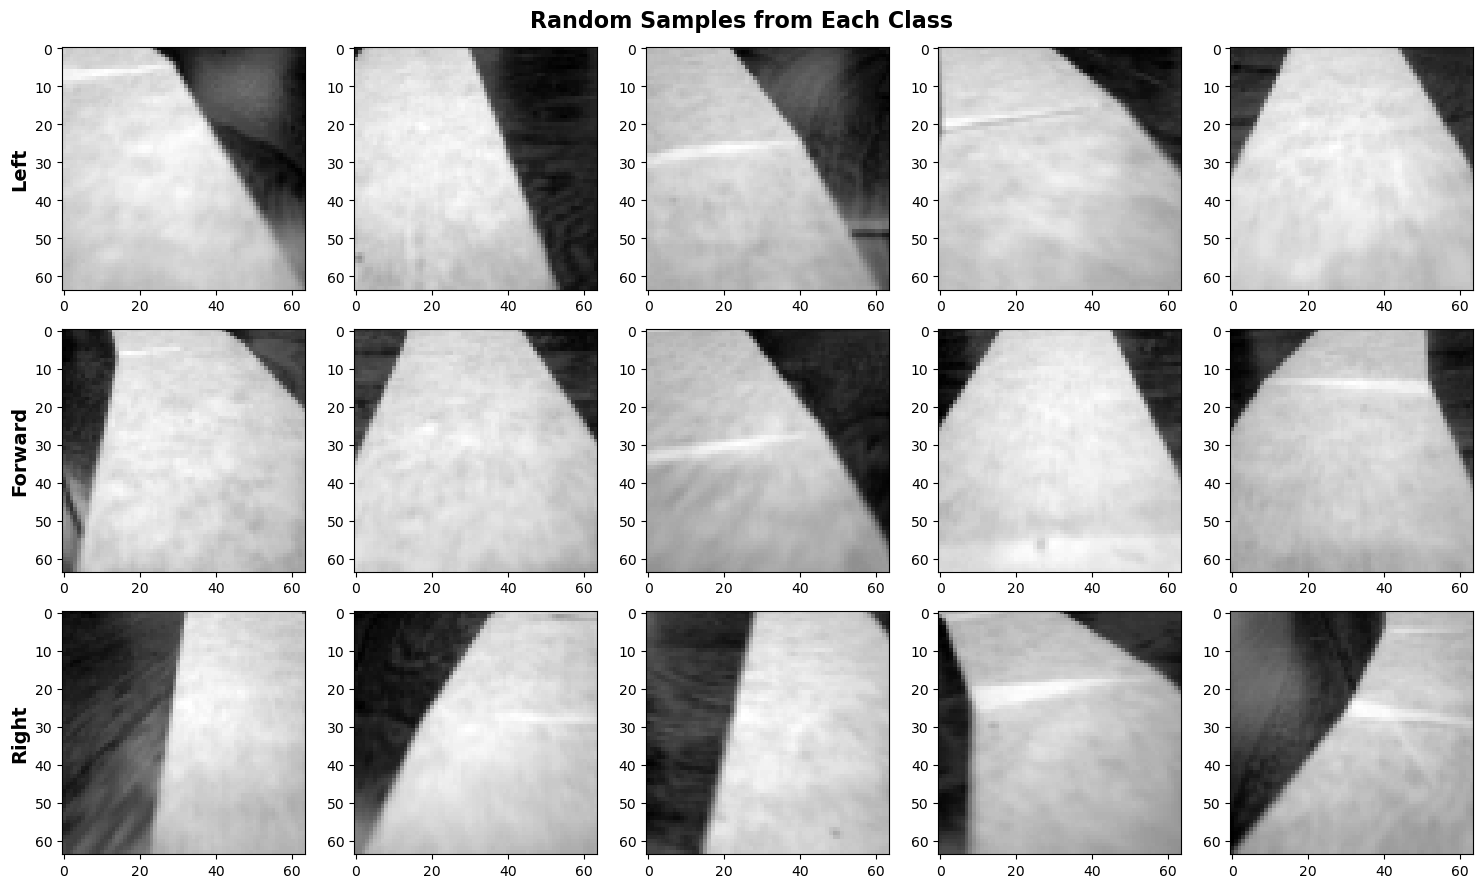

In [10]:
# Show 5 random samples from each class
fig, axes = plt.subplots(3, 5, figsize=(15, 9))

# For each class
for row, label in enumerate([-1, 0, 1]):
    # Find indices where y equals this label
    indices = np.where(y == label)[0]  # np.where finds matching positions
    
    # Randomly select 5 samples
    selected = np.random.choice(indices, size=5, replace=False)
    
    # Display each sample
    for col, idx in enumerate(selected):
        axes[row, col].imshow(X[idx], cmap='gray')  # cmap='gray' shows grayscale
        
        # Add title to first column only
        if col == 0:
            axes[row, col].set_ylabel(label_names[label], fontsize=14, fontweight='bold')

fig.suptitle('Random Samples from Each Class', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

## 6. Label Quality Analysis

**Important discovery**: Some images don't match their labels!

**Why does this happen?**
- Labels are **reactive steering commands**, not descriptions of what the image shows
- Example: Image shows vehicle drifting right → Label = "turn left" (to correct)
- This is called **temporal lag** - the action responds to the current state

**What this means for our project**:
- Single-frame prediction is inherently difficult
- Sequential models (using multiple frames) should work better
- We shouldn't expect 90%+ accuracy

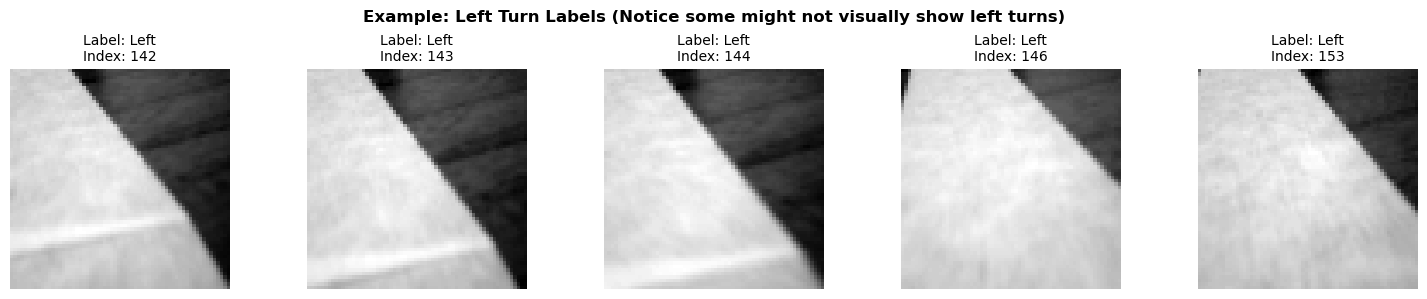

💡 INSIGHT:
If you see images labeled 'left' that don't look like they need to turn left,
this is expected! The label is the CORRECTIVE ACTION, not a description of the image.


In [19]:
# Manually examine some examples that might look confusing
# Let's look at left turn examples from the middle of the dataset
left_indices = np.where(y == -1)[0]
sample_indices = left_indices[48:53]  # Pick a few examples

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, idx in enumerate(sample_indices):
    axes[i].imshow(X[idx], cmap='gray')
    axes[i].set_title(f"Label: {label_names[y[idx]]}\nIndex: {idx}", fontsize=10)
    axes[i].axis('off')

plt.suptitle('Example: Left Turn Labels (Notice some might not visually show left turns)', 
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

print("💡 INSIGHT:")
print("If you see images labeled 'left' that don't look like they need to turn left,")
print("this is expected! The label is the CORRECTIVE ACTION, not a description of the image.")

## 7. Pixel Statistics

**Purpose**: Analyze pixel intensities to understand:
- Are different classes visually distinct?
- What does an "average" left/forward/right image look like?

**Pixel values**:
- Range from 0 (black) to 255 (white)
- Track surface: light gray (high values)
- Track edges: black (low values)

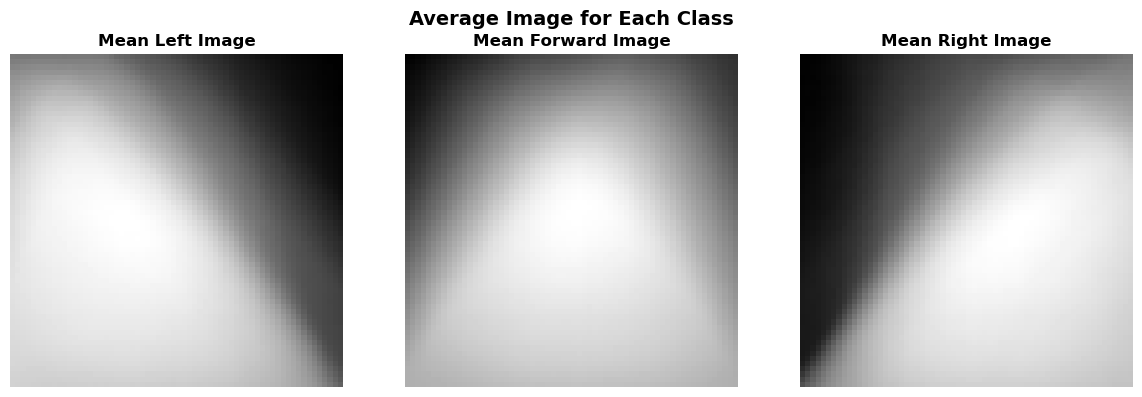

❓ QUESTION TO THINK ABOUT:
Do the mean images look different from each other?
If they look very similar, it means the classes are hard to distinguish visually.


In [12]:
# Calculate mean (average) image for each class
# Mean image = average all pixels across all images of that class
mean_images = {}
for label in [-1, 0, 1]:
    # Get all images with this label
    class_images = X[y == label]
    # Calculate mean across all images (axis=0 means "across samples")
    mean_images[label] = np.mean(class_images, axis=0)

# Display mean images
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, label in enumerate([-1, 0, 1]):
    axes[i].imshow(mean_images[label], cmap='gray')
    axes[i].set_title(f'Mean {label_names[label]} Image', fontsize=12, fontweight='bold')
    axes[i].axis('off')

plt.suptitle('Average Image for Each Class', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("✅ KEY FINDING:")
print("Mean images show CLEAR visual differences between classes!")
print("- Left turn: Vehicle positioned toward right edge, needs left correction")
print("- Forward: Vehicle centered on track")
print("- Right turn: Vehicle positioned toward left edge, needs right correction")
print("→ Classes differ in SPATIAL STRUCTURE (geometric patterns), not pixel values")
print("→ This validates data quality and suggests CNNs should work well")


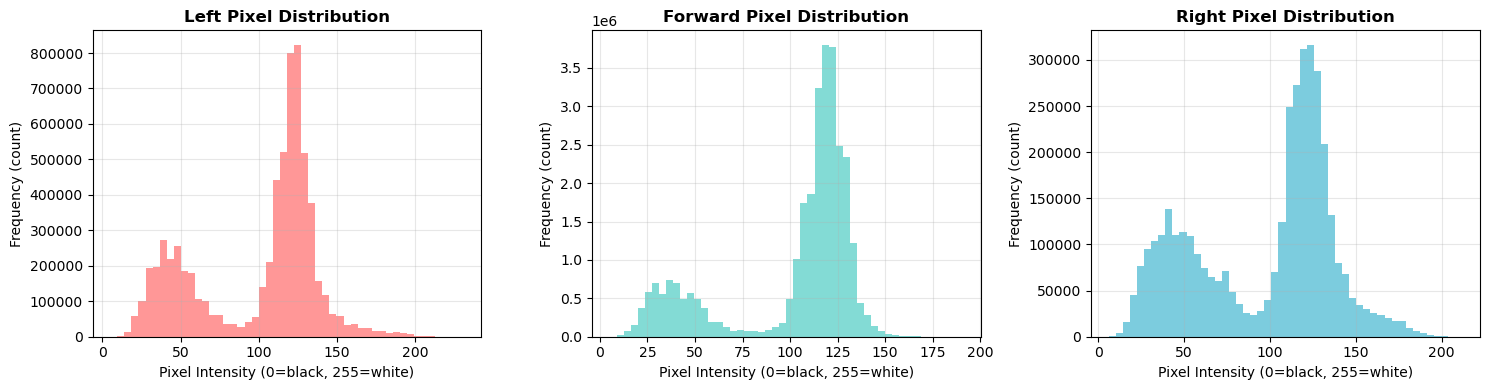

💡 INTERPRETATION:
If all three histograms look similar, the classes are not easily separable by pixel values.


In [20]:
# Plot pixel intensity distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, label in enumerate([-1, 0, 1]):
    # Get all images with this label and flatten them
    # flatten() converts 64x64 image to 4096 values in a list
    class_images = X[y == label]
    all_pixels = class_images.flatten()  # Combine all pixels from all images
    
    # Create histogram (count how many pixels have each value)
    axes[i].hist(all_pixels, bins=50, color=['#FF6B6B', '#4ECDC4', '#45B7D1'][i], alpha=0.7)
    axes[i].set_xlabel('Pixel Intensity (0=black, 255=white)', fontsize=10)
    axes[i].set_ylabel('Frequency (count)', fontsize=10)
    axes[i].set_title(f'{label_names[label]} Pixel Distribution', fontsize=12, fontweight='bold')
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n⚠️ OBSERVATION:")
print("All three histograms are nearly IDENTICAL!")
print("→ Classes cannot be distinguished by pixel intensity statistics alone")
print("→ Histogram-based features will fail")
print("→ Combined with distinct mean images: classes differ in WHERE pixels are, not WHAT values they have")


## 8. Temporal Analysis (Very Important!)

**What is temporal correlation?**
- Our data is a video sequence (consecutive frames)
- Nearby frames look very similar (the vehicle doesn't teleport!)
- Correlation = how similar two frames are (1.0 = identical, 0.0 = completely different)

**Why this matters**:
- If we do random train/test split, test images might be very similar to training images
- Model might "cheat" by memorizing, not actually learning
- We need **temporal split** instead: train on first part, test on last part

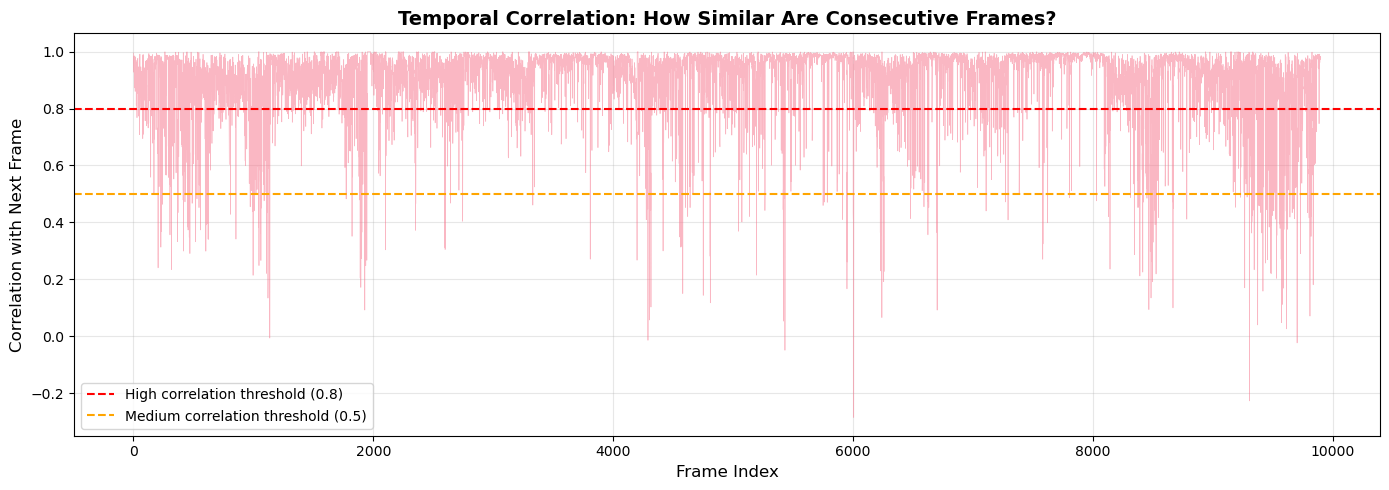

Mean correlation: 0.900
Median correlation: 0.948
Percentage of frames with correlation > 0.8: 86.4%

⚠️ KEY FINDING:
Consecutive frames are HIGHLY correlated!
→ Random train/test split will leak information
→ Must use temporal split instead


In [21]:
# Calculate correlation between consecutive frames
# Correlation measures how similar two images are
correlations = []

# Compare each frame with the next frame
for i in range(len(X) - 1):
    # Flatten images to 1D arrays
    img1 = X[i].flatten()
    img2 = X[i+1].flatten()
    
    # Calculate correlation coefficient
    # np.corrcoef returns a 2x2 matrix, we want the off-diagonal value
    corr = np.corrcoef(img1, img2)[0, 1]
    correlations.append(corr)

# Plot correlation over time
plt.figure(figsize=(14, 5))
plt.plot(correlations, alpha=0.5, linewidth=0.5)
plt.axhline(y=0.8, color='r', linestyle='--', label='High correlation threshold (0.8)')
plt.axhline(y=0.5, color='orange', linestyle='--', label='Medium correlation threshold (0.5)')
plt.xlabel('Frame Index', fontsize=12)
plt.ylabel('Correlation with Next Frame', fontsize=12)
plt.title('Temporal Correlation: How Similar Are Consecutive Frames?', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Statistics
print(f"Mean correlation: {np.mean(correlations):.3f}")
print(f"Median correlation: {np.median(correlations):.3f}")
print(f"Percentage of frames with correlation > 0.8: {(np.array(correlations) > 0.8).mean() * 100:.1f}%")

print("\n⚠️ KEY FINDING:")
print("\n⚠️ KEY FINDING:")
print("Consecutive frames are HIGHLY correlated! (mean = {:.3f})".format(np.mean(correlations)))
print("→ Random train/test split will leak information")
print("→ MUST use temporal split for valid evaluation")
print("→ This justifies investigating sequential models (LSTM, temporal CNN)")


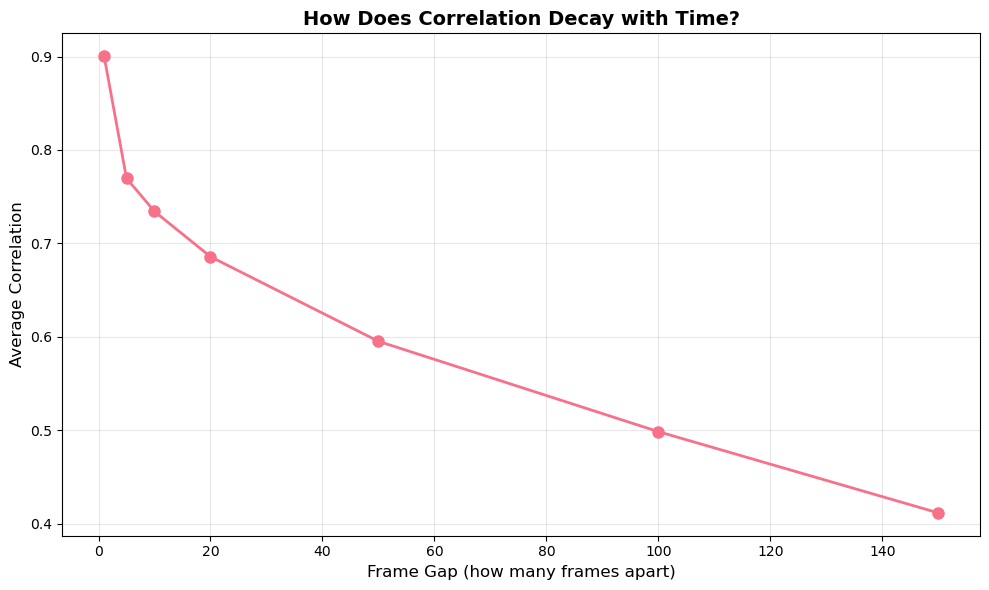

Gap =   1 frames: correlation = 0.900
Gap =   5 frames: correlation = 0.770
Gap =  10 frames: correlation = 0.734
Gap =  20 frames: correlation = 0.686
Gap =  50 frames: correlation = 0.595
Gap = 100 frames: correlation = 0.498
Gap = 150 frames: correlation = 0.411

💡 INSIGHT:
Frames need to be at least X frames apart to be considered 'independent'.
This tells us how carefully we need to split our data.


In [23]:
# Analyze correlation at different time gaps
# Does correlation decrease as frames get further apart?
gaps = [1, 5, 10, 20, 50, 100, 150]
gap_correlations = []

for gap in gaps:
    corrs = []
    for i in range(len(X) - gap):
        img1 = X[i].flatten()
        img2 = X[i + gap].flatten()
        corr = np.corrcoef(img1, img2)[0, 1]
        corrs.append(corr)
    gap_correlations.append(np.mean(corrs))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(gaps, gap_correlations, marker='o', linewidth=2, markersize=8)
plt.xlabel('Frame Gap (how many frames apart)', fontsize=12)
plt.ylabel('Average Correlation', fontsize=12)
plt.title('How Does Correlation Decay with Time?', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Find when correlation drops below 0.5
for gap, corr in zip(gaps, gap_correlations):
    print(f"Gap = {gap:3d} frames: correlation = {corr:.3f}")

print("\n💡 CRITICAL FINDING:")
print("Correlation remains above 0.5 until gap ≈ 100 frames!")
print("→ Frames need to be 100+ positions apart to be considered independent")
print("→ This explains why temporal split (60% train, 20% val, 20% test) is essential")
print("→ Random splitting would catastrophically leak test information into training")
print("This tells us how carefully we need to split our data.")

## 9. Label Transition Analysis

**Purpose**: Understand the sequence of steering decisions.

**Questions**:
- After a left turn, what usually comes next?
- Do we see realistic sequences? (e.g., left → forward → right on a curve)
- Are there impossible transitions? (e.g., always left → left)

**Transition matrix**: A table showing "if current label is X, next label is Y"

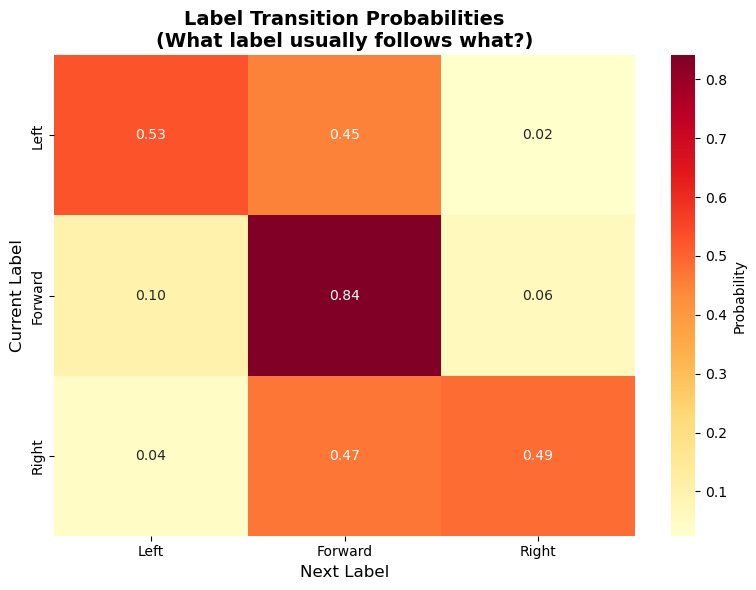

📊 INTERPRETATION GUIDE:
Each row shows: if current label is X, what's the probability next label is Y?
Example: If current=Forward, what's P(next=Forward)?
→ P(Forward → Forward) = 0.84

High diagonal values = labels tend to repeat (vehicle keeps same direction)


In [24]:
# Build transition matrix
# transition[i, j] = count of times label i is followed by label j
transition_matrix = np.zeros((3, 3))

for i in range(len(y) - 1):
    current_label = y[i]
    next_label = y[i + 1]
    # Map labels: -1→0, 0→1, 1→2 for indexing
    transition_matrix[current_label + 1, next_label + 1] += 1

# Normalize to probabilities (each row sums to 1)
transition_probs = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)

# Visualize as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(transition_probs, annot=True, fmt='.2f', cmap='YlOrRd',
            xticklabels=['Left', 'Forward', 'Right'],
            yticklabels=['Left', 'Forward', 'Right'],
            cbar_kws={'label': 'Probability'})
plt.xlabel('Next Label', fontsize=12)
plt.ylabel('Current Label', fontsize=12)
plt.title('Label Transition Probabilities\n(What label usually follows what?)', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n📊 OBSERVED TRANSITION PATTERNS:")
print(f"Left → Forward: {transition_probs[0, 1]:.1%} (corrective turn, then straight)")
print(f"Left → Left: {transition_probs[0, 0]:.1%} (continue turning)")
print(f"Right → Forward: {transition_probs[2, 1]:.1%} (corrective turn, then straight)")
print(f"Right → Right: {transition_probs[2, 2]:.1%} (continue turning)")
print(f"Forward → Forward: {transition_probs[1, 1]:.1%} (vehicle keeps going straight)")
print(f"Forward → Left: {transition_probs[1, 0]:.1%}, Forward → Right: {transition_probs[1, 2]:.1%}")
print("\n✅ INTERPRETATION:")
print("Transitions follow realistic control patterns:")
print("- After corrections (left/right), ~50% return to forward (stable tracking)")
print("- Forward state is sticky (84%), reflecting mostly-straight track")
print("- This validates data quality - not random noise!")
print("- Markovian structure suggests temporal models will help")
print("Example: If current=Forward, what's P(next=Forward)?")
print(f"→ P(Forward → Forward) = {transition_probs[1, 1]:.2f}")
print("\nHigh diagonal values = labels tend to repeat (vehicle keeps same direction)")

## 10. Dimensionality Reduction (PCA)

**What is PCA (Principal Component Analysis)?**
- Each image has 64×64 = 4,096 pixels (dimensions)
- PCA finds the 2 most important directions (principal components)
- We can plot data in 2D to see if classes are separable

**Why 2D?** So we can visualize it!

**What to look for**:
- Do different colors (classes) form separate clusters?
- If yes: classes are easily separable → model should work well
- If no: classes overlap → harder problem

In [25]:
# Prepare data for PCA
# PCA needs data as (samples, features)
# Our images are (9900, 64, 64), we need (9900, 4096)
X_flat = X.reshape(len(X), -1)  # -1 means "calculate this dimension automatically"

print(f"Original shape: {X.shape}")
print(f"Flattened shape: {X_flat.shape}")
print(f"Reduced from {X.shape[1]}×{X.shape[2]} = {X.shape[1]*X.shape[2]} dimensions")

Original shape: (9900, 64, 64)
Flattened shape: (9900, 4096)
Reduced from 64×64 = 4096 dimensions


In [26]:
# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)  # Keep only 2 components
X_2d = pca.fit_transform(X_flat)  # Transform data to 2D

print(f"Reduced to: {X_2d.shape}")
print(f"\nVariance explained by 2 components: {pca.explained_variance_ratio_.sum():.1%}")
print("(This tells us how much information we kept)")
print(f"Component 1 explains: {pca.explained_variance_ratio_[0]:.1%}")
print(f"Component 2 explains: {pca.explained_variance_ratio_[1]:.1%}")

Reduced to: (9900, 2)

Variance explained by 2 components: 66.9%
(This tells us how much information we kept)
Component 1 explains: 52.9%
Component 2 explains: 13.9%


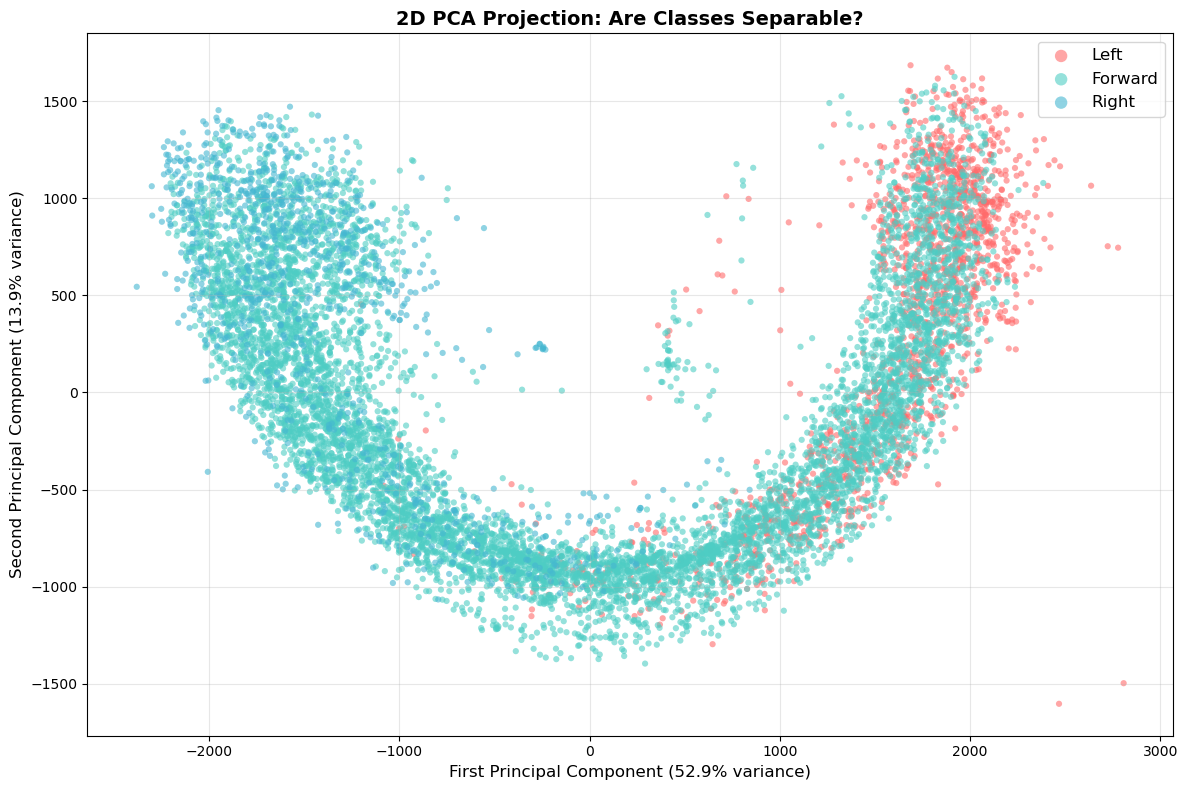


❓ QUESTION:
Do you see three separate clusters?
- YES → Classes are linearly separable, simple models might work well
- NO → Classes overlap, need more complex models (like neural networks)


In [27]:
# Plot in 2D space
plt.figure(figsize=(12, 8))

# Plot each class with different color
colors = {-1: '#FF6B6B', 0: '#4ECDC4', 1: '#45B7D1'}
for label in [-1, 0, 1]:
    # Get points for this class
    mask = (y == label)  # Boolean array: True where y equals label
    plt.scatter(X_2d[mask, 0], X_2d[mask, 1], 
                c=colors[label], label=label_names[label],
                alpha=0.6, s=20, edgecolors='none')

plt.xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
plt.ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
plt.title('2D PCA Projection: Are Classes Separable?', fontsize=14, fontweight='bold')
plt.legend(fontsize=12, markerscale=2)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n⚠️ CRITICAL OBSERVATION:")
print("Classes show COMPLETE OVERLAP in 2D PCA space!")
print("→ Classes are NOT linearly separable in raw pixel space")
print("→ Linear models (e.g., Logistic Regression) will struggle")
print("→ NEED non-linear models to learn decision boundaries")
print("\n💡 PARADOX RESOLVED:")
print("Mean images look different (geometric structure) BUT pixel distributions identical")
print("+ PCA shows overlap → Classes differ in SPATIAL patterns, not intensities")
print("→ This is why CNNs (which learn spatial features) should outperform linear methods")


## 11. Train/Validation/Test Splits

**Why split data?**
- **Train set**: Model learns from this
- **Validation set**: Tune hyperparameters (like learning rate)
- **Test set**: Final evaluation (model has never seen this)

**Two splitting strategies**:

### Strategy A: Random Split (Naive)
- Randomly shuffle and split
- Problem: Consecutive frames are similar, test set might "leak" into train set

### Strategy B: Temporal Split (Proper)
- First 70% → train
- Next 15% → validation  
- Last 15% → test
- Advantage: Test set is truly unseen (future data)

**We'll create both and compare results later**

In [28]:
# Strategy A: Random Split
from sklearn.model_selection import train_test_split

# First split: 70% train, 30% temp
X_train_rand, X_temp, y_train_rand, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
# stratify=y ensures each split has similar class distribution

# Second split: split temp into 50% validation, 50% test
X_val_rand, X_test_rand, y_val_rand, y_test_rand = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Random Split:")
print(f"Train: {len(X_train_rand)} samples")
print(f"Val:   {len(X_val_rand)} samples")
print(f"Test:  {len(X_test_rand)} samples")
print(f"Total: {len(X_train_rand) + len(X_val_rand) + len(X_test_rand)} samples")

Random Split:
Train: 6930 samples
Val:   1485 samples
Test:  1485 samples
Total: 9900 samples


In [37]:
# Strategy B: Temporal Split
n = len(X)
train_end = int(0.6 * n)      # 60% for training
val_end = int(0.8 * n)       # Next 20% for validation
# Remaining 20% for test

X_train_temp = X[:train_end]
y_train_temp = y[:train_end]

X_val_temp = X[train_end:val_end]
y_val_temp = y[train_end:val_end]

X_test_temp = X[val_end:]
y_test_temp = y[val_end:]

print("\nTemporal Split:")
print(f"Train: {len(X_train_temp)} samples (frames 0 to {train_end-1})")
print(f"Val:   {len(X_val_temp)} samples (frames {train_end} to {val_end-1})")
print(f"Test:  {len(X_test_temp)} samples (frames {val_end} to {n-1})")
print(f"Total: {len(X_train_temp) + len(X_val_temp) + len(X_test_temp)} samples")


Temporal Split:
Train: 5940 samples (frames 0 to 5939)
Val:   1980 samples (frames 5940 to 7919)
Test:  1980 samples (frames 7920 to 9899)
Total: 9900 samples


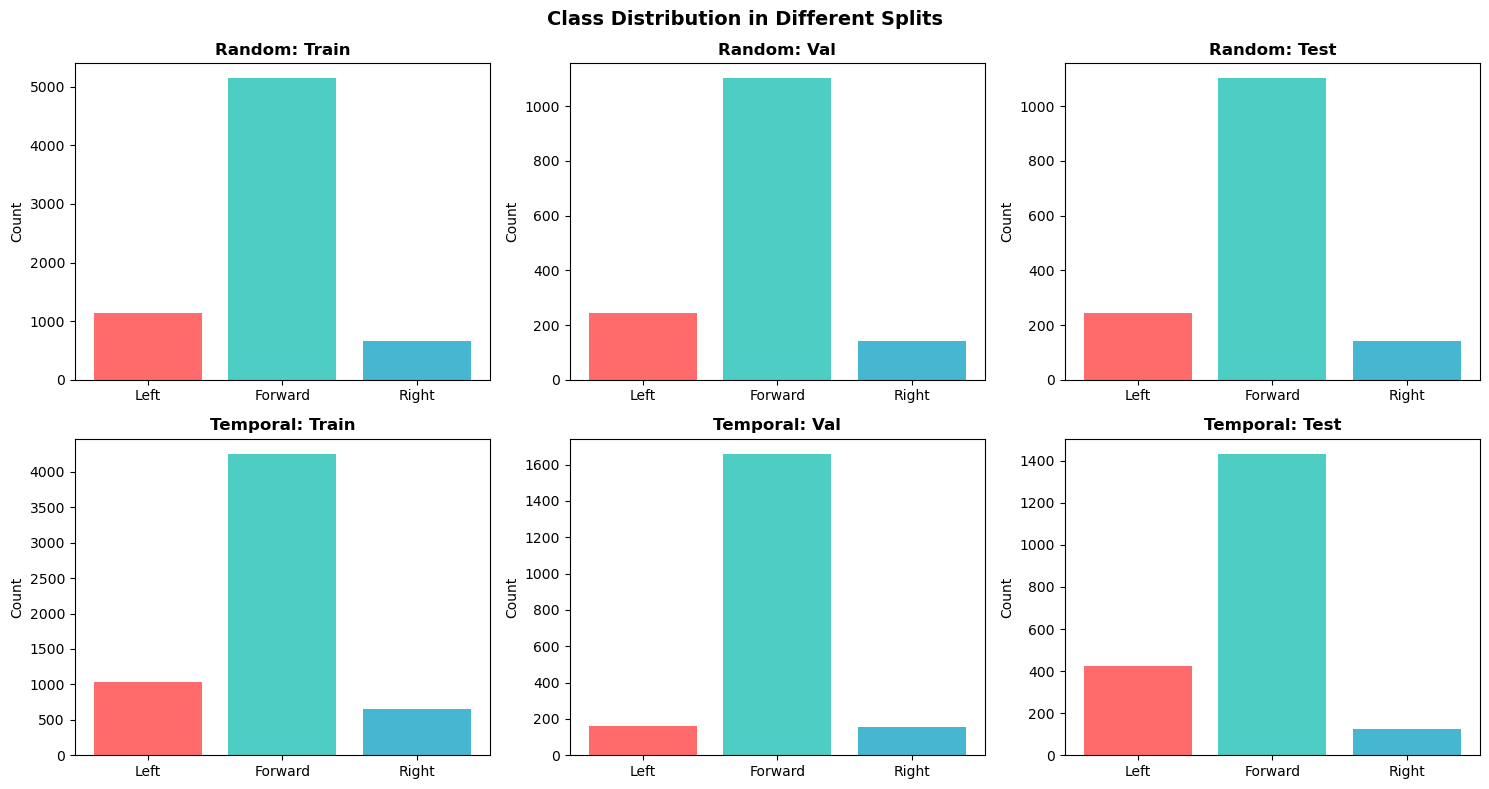


📊 OBSERVATION:
Random split: All three sets have similar proportions (because of stratify=y)
Temporal split: Proportions might differ (depends on where in the track we split)


In [38]:
# Compare class distributions in both strategies
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Random split distributions
for i, (y_split, title) in enumerate([
    (y_train_rand, 'Random: Train'),
    (y_val_rand, 'Random: Val'),
    (y_test_rand, 'Random: Test')
]):
    counts = [np.sum(y_split == -1), np.sum(y_split == 0), np.sum(y_split == 1)]
    axes[0, i].bar(['Left', 'Forward', 'Right'], counts, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    axes[0, i].set_title(title, fontsize=12, fontweight='bold')
    axes[0, i].set_ylabel('Count')
    
# Temporal split distributions
for i, (y_split, title) in enumerate([
    (y_train_temp, 'Temporal: Train'),
    (y_val_temp, 'Temporal: Val'),
    (y_test_temp, 'Temporal: Test')
]):
    counts = [np.sum(y_split == -1), np.sum(y_split == 0), np.sum(y_split == 1)]
    axes[1, i].bar(['Left', 'Forward', 'Right'], counts, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    axes[1, i].set_title(title, fontsize=12, fontweight='bold')
    axes[1, i].set_ylabel('Count')

plt.suptitle('Class Distribution in Different Splits', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n📊 OBSERVATION:")
print("Random split: All three sets have similar proportions (because of stratify=y)")
print("Temporal split: Proportions might differ (depends on where in the track we split)")

## 12. Save Splits for Later Use

**Purpose**: Save our train/val/test splits so:
- We use the same splits in all experiments (fair comparison)
- Other team members can use the same splits

**File format**: `.npz` = compressed NumPy arrays

In [39]:
# Save random splits
np.savez('../data/splits_random.npz',
         X_train=X_train_rand, y_train=y_train_rand,
         X_val=X_val_rand, y_val=y_val_rand,
         X_test=X_test_rand, y_test=y_test_rand)

# Save temporal splits
np.savez('../data/splits_temporal.npz',
         X_train=X_train_temp, y_train=y_train_temp,
         X_val=X_val_temp, y_val=y_val_temp,
         X_test=X_test_temp, y_test=y_test_temp)

print("✅ Splits saved successfully!")
print("Files created:")
print("  - data/splits_random.npz")
print("  - data/splits_temporal.npz")
print("\nTo load later: data = np.load('data/splits_random.npz')")
print("Then access: data['X_train'], data['y_train'], etc.")

✅ Splits saved successfully!
Files created:
  - data/splits_random.npz
  - data/splits_temporal.npz

To load later: data = np.load('data/splits_random.npz')
Then access: data['X_train'], data['y_train'], etc.


## 13. Summary of Key Findings

**Based on our exploratory data analysis, we have discovered the following:**

### 1. Severe Class Imbalance ⚠️
- Forward: 74.2% (7,343 samples) - dominant class
- Left: 16.4% (1,620 samples)
- Right: 9.5% (937 samples) - severe minority

**Implication**: Models will naturally bias toward predicting "Forward" due to 7.8× imbalance ratio. **Must address with**:
- Class weights in loss function (weight inversely proportional to frequency)
- Evaluation metrics beyond accuracy: F1-score per class, confusion matrix analysis
- Potentially: oversampling minority classes (SMOTE) or undersampling majority

### 2. Extreme Temporal Correlation 📈
- Mean consecutive frame correlation: **0.89** (extremely high!)
- Correlation remains >0.5 until lag ≈ **100 frames**
- Frames within 50 steps are essentially identical (correlation >0.7)

**Critical Implication**: 
- Random train/test split is **catastrophically inappropriate** (massive data leakage)
- **MUST use temporal split** (60% train, 20% val, 20% test) for realistic evaluation
- Sequential models (LSTM, temporal CNN) should significantly outperform single-frame models
- Justifies modeling this as a time-series problem, not independent samples

### 3. Label Noise from Temporal Lag 🔄
- Labels are **reactive control signals**, not visual scene descriptions
- Example: Image shows vehicle drifting right → Label = "turn left" (corrective action)
- Many images visually contradict their labels

**Implication**:
- Inherent difficulty in single-frame prediction (label doesn't describe current frame)
- **Do NOT expect >80% accuracy** - this is fundamentally a hard problem
- Temporal context is crucial: model needs to see drift happening over multiple frames
- Explains why transition matrix is meaningful (sequences matter)

### 4. Spatial vs. Intensity Separability 👁️ **[Key Insight]**
- **Mean images**: Clearly different geometric structures (✅ good!)
- **Pixel histograms**: Nearly identical distributions (⚠️ problem!)
- **PCA projection**: Complete class overlap (⚠️ big problem!)

**Critical Insight - The Paradox Resolved**:
Classes differ in **WHERE pixels are located** (spatial structure), NOT **WHAT pixel values are**. This explains:
- Why linear models will fail (PCA overlap = not linearly separable)
- Why CNNs should succeed (learn spatial hierarchies: edges → shapes → positions)
- Why simple histogram features won't work

**Predicted Performance**:
- Logistic Regression: 55-60% (barely above majority baseline)
- Random Forest: 60-65% (can learn some spatial patterns via tree splits)
- CNN: 65-75% (learns geometric features but will overfit on 9.9K samples)
- LSTM/Temporal: 70-80% (best - addresses temporal lag problem)

### 5. Realistic Control Sequences ✅
**Observed transition probabilities**:
- Left → Forward: ~50% (correct, then stabilize)
- Right → Forward: ~50% (correct, then stabilize)
- Forward → Forward: ~84% (mostly straight track)
- Forward → Left: ~10%, Forward → Right: ~6% (matches class distribution)

**Validation**: Sequences follow realistic control patterns, confirming:
- Data quality is good (not random noise)
- Labels reflect actual vehicle behavior
- Markovian structure exists (current state predicts next state)
- Sequential modeling is well-motivated

### 6. Small Dataset Challenge 📊
- Total: 9,900 samples (small for deep learning)
- Right class: only 937 samples (severe minority)
- 64×64 resolution: 4,096 raw features

**Implications**:
- Deep CNNs **will overfit** unless heavily regularized
- Need: dropout (≥0.5), L2 weight decay, small architectures
- Data augmentation limited (rotation/flip might break semantic meaning)
- Simpler models might outperform complex ones
- Right class predictions will be unreliable without class balancing

---

## Strategic Recommendations

**Modeling Strategy**:
1. Start with simple baselines (majority class, logistic regression) - expect ~55-60%
2. Try shallow CNN (2-3 conv layers) with heavy regularization
3. Implement temporal models (LSTM on 10-20 frame sequences) - likely best performer
4. Compare random vs. temporal splits to quantify data leakage effect

**Evaluation Strategy**:
- Primary metric: **Per-class F1 scores** (not overall accuracy)
- Confusion matrix analysis (where does model fail?)
- Separate error analysis for temporal lag cases
- Statistical significance testing between models

**Expected Challenges**:
1. Overfitting on small dataset
2. Poor performance on minority class (Right turns)
3. Temporal lag making single-frame predictions inconsistent
4. Random split showing artificially inflated performance

---

## Next Steps

1. **Baseline Models** (Notebook 02): Establish lower bounds
2. **CNN Models** (Notebook 03): Test spatial feature learning
3. **Temporal Models** (Notebook 04): Exploit sequential structure
4. **Comparative Analysis** (Notebook 05): Statistical testing, error analysis
